# PGExplainer on BA-Shapes dataset for 2-layer GCN

In [1]:
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
import torch
from torch_geometric.data import DataLoader
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_zip
import os.path as osp
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [2]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

def split_dataset(dataset):
    indices = []
    num_classes = 4
    train_percent = 0.7
    for i in range(num_classes):
        index = (dataset.data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)

    train_index = torch.cat([i[:int(len(i) * train_percent)] for i in indices], dim=0)

    rest_index = torch.cat([i[int(len(i) * train_percent):] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
    dataset.data.val_mask = index_to_mask(rest_index[:len(rest_index) // 2], size=dataset.data.num_nodes)
    dataset.data.test_mask = index_to_mask(rest_index[len(rest_index) // 2:], size=dataset.data.num_nodes)

    dataset.data, dataset.slices = dataset.collate([dataset.data])

    return dataset

dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset.data.x = dataset.data.x.to(torch.float32)
dataset.data.x = dataset.data.x[:, :1]
# dataset.data.y = dataset.data.y[:, 2]
dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
# num_targets = dataset.num_classes
num_classes = dataset.num_classes

splitted_dataset = split_dataset(dataset)
splitted_dataset.data.mask = splitted_dataset.data.test_mask
splitted_dataset.slices['mask'] = splitted_dataset.slices['train_mask']
dataloader = DataLoader(splitted_dataset, batch_size=1, shuffle=False)

### Load model and checkpoints

In [3]:
def check_checkpoints(root='./'):
    if osp.exists(osp.join(root, 'checkpoints')):
        return
    url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
    path = download_url(url, root)
    extract_zip(path, root)
    os.unlink(path)

model = GCN_2l_mask(model_level='node', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
model.to(device)
check_checkpoints()
ckpt_path = osp.join('checkpoints', 'ba_shapes', 'GCN_2l', '0', 'GCN_2l_best.ckpt')
model.load_state_dict(torch.load(ckpt_path)['state_dict'])

<All keys matched successfully>

In [4]:
from dig.xgraph.method import PGExplainer
explainer = PGExplainer(model, in_channels=900, device=device, explain_graph=False)

explainer.train_explanation_network(splitted_dataset)
torch.save(explainer.state_dict(), 'tmp.pt')
state_dict = torch.load('tmp.pt')
explainer.load_state_dict(state_dict)

100%|██████████| 560/560 [00:09<00:00, 58.38it/s]
560it [00:45, 12.25it/s]
560it [00:45, 12.22it/s]
560it [00:45, 12.22it/s]
560it [00:46, 12.09it/s]
560it [00:46, 12.12it/s]
560it [00:46, 12.02it/s]
560it [00:46, 12.00it/s]
560it [00:46, 12.01it/s]
560it [00:46, 12.04it/s]
560it [00:46, 12.04it/s]
560it [00:46, 12.04it/s]
560it [00:46, 11.94it/s]
560it [00:47, 11.91it/s]
560it [00:47, 11.90it/s]
560it [00:46, 11.94it/s]
560it [00:47, 11.80it/s]
560it [00:47, 11.86it/s]
560it [00:47, 11.75it/s]
560it [00:47, 11.80it/s]
560it [00:47, 11.87it/s]


Epoch: 0 | Loss: 2455.615709577288
Epoch: 1 | Loss: 2288.086938912528
Epoch: 2 | Loss: 2088.094579424177
Epoch: 3 | Loss: 1842.0066970825196
Epoch: 4 | Loss: 1559.0839226858957
Epoch: 5 | Loss: 1256.447160230364
Epoch: 6 | Loss: 958.6352490561349
Epoch: 7 | Loss: 689.6191911152431
Epoch: 8 | Loss: 466.7381445816585
Epoch: 9 | Loss: 296.6048153127943
Epoch: 10 | Loss: 176.6741455393178
Epoch: 11 | Loss: 98.82285667295967
Epoch: 12 | Loss: 52.08865845062371
Epoch: 13 | Loss: 26.060334627489958
Epoch: 14 | Loss: 12.478980255459984
Epoch: 15 | Loss: 5.769681178105851
Epoch: 16 | Loss: 2.6059776619256483
Epoch: 17 | Loss: 1.1623430149592489
Epoch: 18 | Loss: 0.5174378917963265
Epoch: 19 | Loss: 0.2349195941371168
training time is 934.24s


<All keys matched successfully>

### Visualization

D:\Programs\DIG_package\dig\xgraph\method\pgexplainer.py:284: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_mask = torch.tensor(edge_mask)


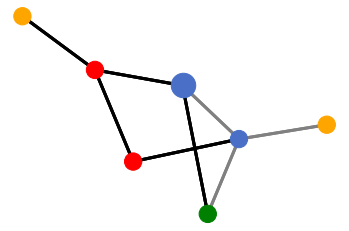

In [5]:
from dig.xgraph.method.pgexplainer import PlotUtils
plotutils = PlotUtils(dataset_name='ba_shapes')

node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
from dig.xgraph.method.pgexplainer import PlotUtils
plotutils = PlotUtils(dataset_name='ba_shapes')
data = dataset[0]
node_idx = node_indices[6]
with torch.no_grad():
    walks, masks, related_preds = \
        explainer(data.x, data.edge_index, node_idx=node_idx, y=data.y, top_k=5)


explainer.visualization(data, edge_mask=masks[0], top_k=5, plot_utils=plotutils, node_idx=node_idx)

 ### Metric results

In [7]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector
x_collector = XCollector()

### Run explainer on the given model and dataset
index = -1
for i, data in enumerate(dataloader):
    for j, node_idx in enumerate(torch.where(data.test_mask)[0].tolist()):
        index += 1
        print(f'explain graph {i} node {node_idx}')
        data.to(device)

        if torch.isnan(data.y[0].squeeze()):
            continue

        with torch.no_grad():
            walks, masks, related_preds = \
                explainer(data.x, data.edge_index, node_idx=node_idx, y=data.y, top_k=5)
            masks = [mask.detach() for mask in masks]
        x_collector.collect_data(masks, related_preds)

        # if you only have the edge masks without related_pred, please feed sparsity controlled mask to
        # obtain the result: x_processor(data, masks, x_collector)
        if index >= 99:
            break

    if index >= 99:
        break

print(f'Fidelity: {x_collector.fidelity:.4f}\n'
      f'Sparsity: {x_collector.sparsity:.4f}')

explain graph 0 node 10
explain graph 0 node 15
explain graph 0 node 22
explain graph 0 node 25
explain graph 0 node 26
explain graph 0 node 43
explain graph 0 node 64
explain graph 0 node 71
explain graph 0 node 75
explain graph 0 node 77
explain graph 0 node 87
explain graph 0 node 96
explain graph 0 node 126
explain graph 0 node 149
explain graph 0 node 151
explain graph 0 node 155
explain graph 0 node 166
explain graph 0 node 190
explain graph 0 node 196
explain graph 0 node 210
explain graph 0 node 243
explain graph 0 node 253
explain graph 0 node 263
explain graph 0 node 269
explain graph 0 node 279
explain graph 0 node 282
explain graph 0 node 288
explain graph 0 node 297
explain graph 0 node 302
explain graph 0 node 313
explain graph 0 node 321
explain graph 0 node 332
explain graph 0 node 336
explain graph 0 node 348
explain graph 0 node 356
explain graph 0 node 367
explain graph 0 node 369
explain graph 0 node 381
explain graph 0 node 387
explain graph 0 node 418
explain grap